# Image Fraud Detection Algorithm Analysis

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.preprocessing import image

DIR = os.getcwd()
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_PIXELS = IMG_HEIGHT*IMG_WIDTH
COLOR_MODE = 'grayscale'
PATH_DATASET_TRAIN = "Datasets/dataset_train/"
PATH_DATASET_TEST = 'Datasets/dataset_test1/'

In [ ]:
plt.rcParams['figure.figsize'] = (12,10)

## Data Loading

Loading a total of 40000 images with 28x28 pixels and grayscale as the color mode. The division is as the following:

- 20000 real images
- 20000 fake images


In [ ]:
def loadDataset():
    train_ds = image_dataset_from_directory(
        PATH_DATASET_TRAIN,
        labels = 'inferred',
        label_mode='binary',
        color_mode=COLOR_MODE,
        image_size=(IMG_HEIGHT,IMG_WIDTH)
    )

    return train_ds.unbatch()
train_ds = loadDataset()

Found 40000 files belonging to 2 classes.


In [ ]:
def formatDataset(dataset):
    X = []
    Y = []
    for img,label in dataset.as_numpy_iterator():
        imgData = np.array([row.flatten() for row in img])
        X.append(imgData.flatten())
        Y.append(label[0])
    X = np.array(X)
    Y = np.array(Y)
    return X/255,Y

In [ ]:
X,Y = formatDataset(train_ds)

We use the tensorflow library to get the data and then use the function formatDataset to return numpy arrays to use for the models training:

- Returns a numpy array with shape (40000,28,28) 
    - 40000 rows equals the 40000 images
    - Inside each row is the information of the image after being loaded
- Also returns another numpy array with shape (40000,1), which the label corresponding to each image
    - Label 0 --> **FAKE**
    - Label 1 --> **REAL**

# **Data Dimension Reduction**

### Principal Component Analysis

- Linear dimensionality reduction technique for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space.
- Speeds up your machine learning algorithm's training and testing time considering your data has a lot of features, and the ML algorithm's learning is too slow.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
totImages = Y.shape[0]

pca = PCA(n_components=200)
X_pca = pca.fit_transform(X)
print('Explained Variance Ratio',sum(pca.explained_variance_ratio_))


Explained Variance Ratio 0.9560265528270975


# **Data Splitting**

## Train - Validation/Test

In this case the validation Ratio is according to the rest of the first split

Example:
- valRatio = 0.5; testRatio = 0.4
- Then 0.5*0.4 = 0.2 so in reality the validation ratio is 20%

8000


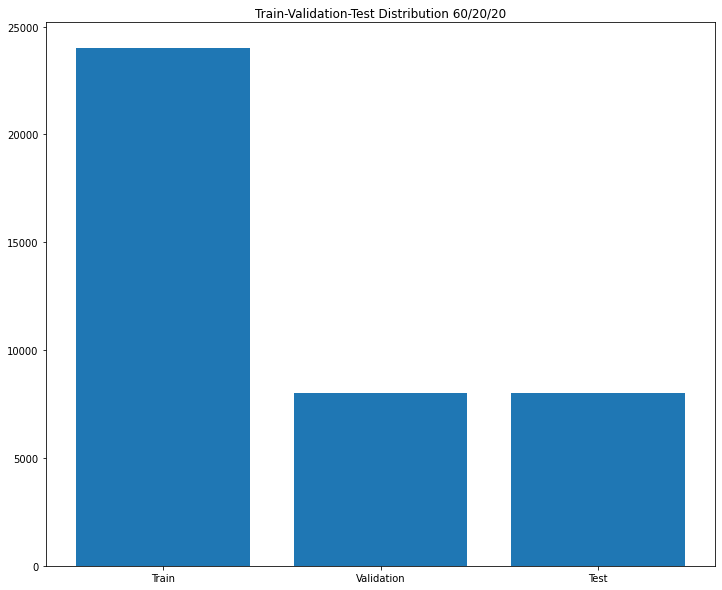

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_pca, Y, test_size=0.4, random_state=13)
X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=0.5, random_state=13)

freqs = [Y_train.shape[0],Y_val.shape[0],Y_test.shape[0]]
print(Y_test.shape[0])

plt.bar([f'Train','Validation','Test'],freqs)
plt.title('Train-Validation-Test Distribution 60/20/20')
plt.show()

# **Models Prediction Analysis**


    


### Evaluation Metrics:
- Accuracy: How many data points are predicted correctly
- Precision: Number of correct positive predictions made out of all positive predictions
- Recall: Number of correct positive predictions made out of all positive predictions that could have been made.
- ROC_AUC:

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
import pandas as pd

metrics = ['accuracy','precision','recall','roc_auc']
finalModels = {}

In [ ]:
def getMetrics(pred,real):
    precision = precision_score(pred,real)
    accuracy = accuracy_score(pred,real)
    recall = recall_score(pred,real)
    roc_auc = roc_auc_score(pred,real)

    return [accuracy, precision, recall, roc_auc]

def showBestModels(df):
    
    best_recall_svm = max(df['recall'])
    svm_name = df['recall'].idxmax()
    print(f'Best recall: {best_recall_svm}\nModel {svm_name}\n')

    best_precision_svm = max(df['precision'])
    svm_name = df['precision'].idxmax()
    print(f'Best precision: {best_precision_svm}\nModel {svm_name} \n')

    best_accuracy_svm = max(df['accuracy'])
    svm_name = df['accuracy'].idxmax()
    print(f'Best accuracy: {best_accuracy_svm}\nModel {svm_name}\n')

    best_roc_auc_svm = max(df['roc_auc'])
    svm_name = df['roc_auc'].idxmax()
    print(f'Best ROC_AUC: {best_roc_auc_svm}\nModel {svm_name}\n')

def formatParamDict(paramsDict):
  for param,val in paramsDict.items():
    paramsDict[param] = [val]
  return paramsDict

def validateModel(name,model,df):
  model.fit(X_train,Y_train)
  pred = model.predict(X_val)
  df.loc[name] = getMetrics(pred)

  print('Accuracy:',df.loc[name]['accuracy'])
  print('Precision:',df.loc[name]['precision'])
  print('Recall:',df.loc[name]['recall'])
  print('ROC_AUC:',df.loc[name]['roc_auc'])
  return model,df


### Support Vector Macinhe (SVM)

- SVM's are algorithms commonly used for supervised machine learning models. 
- High degree of accuracy compared to other classification algorithms such as **K-Nearest Neighbour**
- Separate data into different classes of data by using a hyperplane, supported by the use of **support vectors**
- **Kernel** function transforms the data into a higher dimension
    - Example: <u>Negative sum of the squares</u> of the coordinates for each of these values and have that equal the third dimension of the data
- **Paramter Testing**:
    - Kernel
    - C (Regularization parameter)
    - Gamma

Implementation Code docs: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


In [ ]:
from sklearn.svm import SVC
final_params_SVM = {}
models_SVM = {}
num_svm = 1
best_model_SVM = None

### **Parameter Testing**

We use the sklearn's GridSearchCV to test all the parameters in one go. And then we choose the best model by the accuracy.
Then we if there's another parameter to test, we use the parameters of the best model from the previous testing to the new parameter testing.
The goal of this process is to iterate through the parameters testing until we reach the final model. One of the reasons we decided to this way was to save time in case it would take too much time to use the GridSearch in one go with the all the parameters available. Also to see the progress of the metrics as the parameters change.

#### Kernel Function

In [ ]:

name_param ='kernel'
params = ['linear','poly','rbf','sigmoid']
df_svm_kernel = pd.DataFrame(columns = metrics)

for val in params:
  final_params_SVM.update({name_param:val})
  name = f'SVM{num_svm}'
  model,df_svm_kernel = validateModel(name,SVC(**final_params_SVM),df_svm_kernel)
  models_SVM.update({name:model})
  num_svm +=1

Accuracy: 0.76775
Precision: 0.7624434389140271
Recall: 0.7686264571718195
ROC_AUC: 0.7677616745651895
Accuracy: 0.948625
Precision: 0.9519859225741578
Recall: 0.9450960818567506
ROC_AUC: 0.9486311864330084
Accuracy: 0.95575
Precision: 0.9557566616390146
Recall: 0.9552763819095478
ROC_AUC: 0.9557476436910923
Accuracy: 0.549375
Precision: 0.5437405731523378
Recall: 0.547179357450038
ROC_AUC: 0.5493495008154563


In [ ]:
df_svm_kernel.to_csv('svm_kernel.csv')
df_svm_kernel

,accuracy,precision,recall,roc_auc
SVM1,0.767750,0.762443,0.768626,0.767762
SVM2,0.948625,0.951986,0.945096,0.948631
SVM3,0.955750,0.955757,0.955276,0.955748
SVM4,0.549375,0.543741,0.547179,0.549350


In [ ]:
showBestModels(df_svm_kernel)

Best recall: 0.9552763819095478
Model SVM3

Best precision: 0.9557566616390146
Model SVM3 

Best accuracy: 0.95575
Model SVM3

Best ROC_AUC: 0.9557476436910923
Model SVM3



In [ ]:
best_model_SVM = models_SVM['SVM3']
final_params_SVM.update({'kernel':'rbf'})
final_params_SVM

{'kernel': 'rbf'}

#### C (Regularization parameter)

In [ ]:
name_param ='C'
params = [0.01,0.1,10]
df_svm_c = pd.DataFrame(columns = metrics)

for val in params:
  final_params_SVM.update({name_param:val})
  name = f'SVM{num_svm}'
  model,df_svm_c = validateModel(name,SVC(**final_params_SVM),df_svm_c)
  models_SVM.update({name:model})
  num_svm +=1

Accuracy: 0.651875
Precision: 0.5771744595274007
Recall: 0.6754927919976463
ROC_AUC: 0.6549600452055174
Accuracy: 0.8655
Precision: 0.8763197586726998
Recall: 0.8565110565110565
ROC_AUC: 0.8656601084082
Accuracy: 0.97675
Precision: 0.9751131221719457
Recall: 0.9780635400907716
ROC_AUC: 0.9767610709873789


In [ ]:
df_svm_c.to_csv('svm_c.csv')
df_svm_c

,accuracy,precision,recall,roc_auc
SVM5,0.651875,0.577174,0.675493,0.654960
SVM6,0.865500,0.876320,0.856511,0.865660
SVM7,0.976750,0.975113,0.978064,0.976761


In [ ]:
showBestModels(df_svm_c)

Best recall: 0.9780635400907716
Model SVM7

Best precision: 0.9751131221719457
Model SVM7 

Best accuracy: 0.97675
Model SVM7

Best ROC_AUC: 0.9767610709873789
Model SVM7



In [ ]:
best_model_SVM = models_SVM['SVM7']
final_params_SVM.update({'C':10})

#### Gamma

In [ ]:
name_param ='gamma'
params = [0.01,1,10]
df_svm_gamma = pd.DataFrame(columns = metrics)

for val in params:
  final_params_SVM.update({name_param:val})
  name = f'SVM{num_svm}'
  model,df_svm_gamma = validateModel(name,SVC(**final_params_SVM),df_svm_gamma)
  models_SVM.update({name:model})
  num_svm +=1

Accuracy: 0.972625
Precision: 0.9703368526897939
Recall: 0.974501388538248
ROC_AUC: 0.9726431181364178
Accuracy: 0.61075
Precision: 0.9932126696832579
Recall: 0.5613810741687979
ROC_AUC: 0.7666572730511348
Accuracy: 0.497375
Precision: 1.0
Recall: 0.49731216402050255
ROC_AUC: 0.7486560820102512


In [ ]:
df_svm_gamma.to_csv('svm_gamma.csv')
df_svm_gamma

,accuracy,precision,recall,roc_auc
SVM8,0.972625,0.970337,0.974501,0.972643
SVM9,0.610750,0.993213,0.561381,0.766657
SVM10,0.497375,1.000000,0.497312,0.748656


In [ ]:
showBestModels(df_svm_gamma)

Best recall: 0.974501388538248
Model SVM8

Best precision: 1.0
Model SVM10 

Best accuracy: 0.972625
Model SVM8

Best ROC_AUC: 0.9726431181364178
Model SVM8



Then use the validation set to see the accuracy of the best SVM model

In [ ]:
#CHOSSING THE FINAL SVM MODEL FOR FINAL TESTING

best_model_SVM = models_SVM['SVM8']
final_params_SVM.update({'gamma':0.01})
print('Parameters of the best SVM model',final_params_SVM)
best_model_SVM

Parameters of the best SVM model {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}


SVC(C=10, gamma=0.01)

### Artificial Neural Networks (MLP)
- Capable of learning any <u>non-linear</u> function
- Cannot capture sequential information in the input data which is required for dealing with sequence data
- Consists of 3 layers – Input, Hidden and Output
- The architeture is called Multi Layer Perceptron(MLP) a group of multiple perceptrons/neurons at each layer
- Solve problems related to: Tabular data, Image data and Text data
- **Paramter Testing**:
    - Learning Rate
    - Activation function
    - Solvers
    - Hidden Layer Size

Implementation Code docs: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [ ]:
from sklearn.neural_network import MLPClassifier as MLP
final_params_MLP = {'max_iter':400}
models_MLP = {}
num_MLP = 1
best_model_MLP = None

#### Activation Function

In [ ]:
name_param ='activation'
params = ['identity', 'logistic', 'tanh', 'relu']
df_mlp_activation = pd.DataFrame(columns = metrics)

for val in params:
  final_params_MLP.update({name_param:val})
  name = f'MLP{num_MLP}'
  model,df_mlp_activation = validateModel(name,MLP(**final_params_MLP),df_mlp_activation)
  models_MLP.update({name:model})
  num_MLP +=1

Accuracy: 0.765625
Precision: 0.7644544997486173
Recall: 0.7642623774817794
ROC_AUC: 0.7656178835929166
Accuracy: 0.966375
Precision: 0.9615384615384616
Recall: 0.9705658462319209
ROC_AUC: 0.9664359164640757
Accuracy: 0.962375
Precision: 0.9567621920563097
Recall: 0.9672172808132148
ROC_AUC: 0.9624524288444917
Accuracy: 0.97025
Precision: 0.963298139768728
Recall: 0.9765545361875637
ROC_AUC: 0.9703675526865199


In [ ]:
df_mlp_activation.to_csv('mlp_activation.csv')
df_mlp_activation

,accuracy,precision,recall,roc_auc
MLP1,0.765625,0.764454,0.764262,0.765618
MLP2,0.966375,0.961538,0.970566,0.966436
MLP3,0.962375,0.956762,0.967217,0.962452
MLP4,0.970250,0.963298,0.976555,0.970368


In [ ]:
showBestModels(df_mlp_activation)

Best recall: 0.9765545361875637
Model MLP4

Best precision: 0.963298139768728
Model MLP4 

Best accuracy: 0.97025
Model MLP4

Best ROC_AUC: 0.9703675526865199
Model MLP4



In [ ]:
best_model_MLP = models_MLP['MLP4']
final_params_MLP.update({'activation':'relu'})
print('Parameters of the best MLP model',final_params_MLP)
best_model_MLP

Parameters of the best SVM model {'max_iter': 400, 'activation': 'relu'}


MLPClassifier(max_iter=400)

#### Solvers

In [ ]:
name_param ='solver'
params = ['lbfgs', 'sgd', 'adam']
df_mlp_solver = pd.DataFrame(columns = metrics)

for val in params:
  final_params_MLP.update({name_param:val})
  name = f'MLP{num_MLP}'
  model,df_mlp_solver = validateModel(name,MLP(**final_params_MLP),df_mlp_solver)
  models_MLP.update({name:model})
  num_MLP +=1

Accuracy: 0.958875
Precision: 0.9524886877828054
Recall: 0.9643675235428862
ROC_AUC: 0.9589707919851499


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Accuracy: 0.95075
Precision: 0.9479638009049773
Recall: 0.9527539161192522
ROC_AUC: 0.9507708224831788
Accuracy: 0.969125
Precision: 0.9645550527903469
Recall: 0.9731169160537662
ROC_AUC: 0.9691810855841915


In [ ]:
df_mlp_solver.to_csv('mlp_solver.csv')
df_mlp_solver

,accuracy,precision,recall,roc_auc
MLP5,0.958875,0.952489,0.964368,0.958971
MLP6,0.950750,0.947964,0.952754,0.950771
MLP7,0.969125,0.964555,0.973117,0.969181


In [ ]:
showBestModels(df_mlp_solver)

Best recall: 0.9731169160537662
Model MLP7

Best precision: 0.9645550527903469
Model MLP7 

Best accuracy: 0.969125
Model MLP7

Best ROC_AUC: 0.9691810855841915
Model MLP7



In [ ]:
best_model_MLP = models_MLP['MLP7']
final_params_MLP.update({'solver':'adam'})
print('Parameters of the best MLP model',final_params_MLP)
best_model_MLP

Parameters of the best MLP model {'max_iter': 400, 'activation': 'relu', 'solver': 'adam'}


MLPClassifier(max_iter=400)

#### Learning Rate

In [ ]:
name_param ='learning_rate'
params = ['constant', 'invscaling', 'adaptive']
df_mlp_learning = pd.DataFrame(columns = metrics)

for val in params:
  final_params_MLP.update({name_param:val})
  name = f'MLP{num_MLP}'
  model,df_mlp_learning = validateModel(name,MLP(**final_params_MLP),df_mlp_learning)
  models_MLP.update({name:model})
  num_MLP +=1


Accuracy: 0.973125
Precision: 0.9683257918552036
Recall: 0.9774168992641462
ROC_AUC: 0.973187385330521
Accuracy: 0.969875
Precision: 0.9625439919557567
Recall: 0.976536597806682
ROC_AUC: 0.9700040184424438
Accuracy: 0.971625
Precision: 0.9663147310206134
Recall: 0.9763779527559056
ROC_AUC: 0.9716986982583367


In [ ]:
df_mlp_learning.to_csv('mlp_learning.csv')
df_mlp_learning

,accuracy,precision,recall,roc_auc
MLP8,0.973125,0.968326,0.977417,0.973187
MLP9,0.969875,0.962544,0.976537,0.970004
MLP10,0.971625,0.966315,0.976378,0.971699


In [ ]:
showBestModels(df_mlp_learning)

Best recall: 0.9774168992641462
Model MLP8

Best precision: 0.9683257918552036
Model MLP8 

Best accuracy: 0.973125
Model MLP8

Best ROC_AUC: 0.973187385330521
Model MLP8



In [ ]:
best_model_MLP = models_MLP['MLP8']
final_params_MLP.update({'learning_rate':'constant'})
print('Parameters of the best MLP model',final_params_MLP)
best_model_MLP

Parameters of the best MLP model {'max_iter': 400, 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'constant'}


MLPClassifier(max_iter=400)

#### Hidden Layer Size

In [ ]:
num_MLP = 11

In [ ]:
name_param ='hidden_layer_sizes'
params = [(150,3),(200,4),(250,5),(300,6),(350,5)]
df_mlp_layer = pd.DataFrame(columns = metrics)

for val in params:
  final_params_MLP.update({name_param:val})
  name = f'MLP{num_MLP}'
  model,df_mlp_layer = validateModel(name,MLP(**final_params_MLP),df_mlp_layer)
  models_MLP.update({name:model})
  num_MLP +=1

Accuracy: 0.970875
Precision: 0.9673202614379085
Recall: 0.9739306504682359
ROC_AUC: 0.9709119787288081
Accuracy: 0.958
Precision: 0.9457013574660633
Recall: 0.9690880989180835
ROC_AUC: 0.9583177260010524
Accuracy: 0.972875
Precision: 0.9678230266465561
Recall: 0.9774054328509774
ROC_AUC: 0.9729430513183723
Accuracy: 0.973125
Precision: 0.9705882352941176
Recall: 0.9752462743116949
ROC_AUC: 0.9731465224565156
Accuracy: 0.97375
Precision: 0.9668174962292609
Recall: 0.9801223241590215
ROC_AUC: 0.9738688166428081


In [ ]:
df_mlp_layer.to_csv('mlp_layer.csv')
df_mlp_layer

,accuracy,precision,recall,roc_auc
MLP11,0.970875,0.967320,0.973931,0.970912
MLP12,0.958000,0.945701,0.969088,0.958318
MLP13,0.972875,0.967823,0.977405,0.972943
MLP14,0.973125,0.970588,0.975246,0.973147
MLP15,0.973750,0.966817,0.980122,0.973869


In [ ]:
showBestModels(df_mlp_layer)

Best recall: 0.9801223241590215
Model MLP15

Best precision: 0.9705882352941176
Model MLP14 

Best accuracy: 0.97375
Model MLP15

Best ROC_AUC: 0.9738688166428081
Model MLP15



In [ ]:
#CHOOSING FINAL MODEL MLP
best_model_MLP = models_MLP['MLP15']
final_params_MLP.update({'hidden_layer_sizes':'(350,5)'})
print('Parameters of the best MLP model',final_params_MLP)
best_model_MLP

Parameters of the best MLP model {'max_iter': 400, 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': '(350,5)'}


MLPClassifier(hidden_layer_sizes=(350, 5), max_iter=400)

# Ensembles

It's a machine learning technique that combines several base models in order to produce one optimal predictive model.

The three main classes of ensemble learning methods:
- **Bagging**
- **Voting**
- **Boosting**


### Voting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,cross_val_score

seed = 11
num_trees = 100
df_ensembles = pd.DataFrame(columns = metrics)
best_ensemble_model = None

In [ ]:
models = []
models.append(('LR',LogisticRegression(random_state=seed)))
models.append(('KNN',KNeighborsClassifier()))
models.append(('DT',DecisionTreeClassifier(random_state=seed)))
models.append(('RF',RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB',GaussianNB()))
models.append(('MLP',MLP()))
models.append(('SVM', SVC()))

##### Majority Voting

In [ ]:
v_1 = VotingClassifier(models)
v_1_model = validateModel('Ensemble Voting',v_1,df_ensembles)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.937125
Precision: 0.9321266968325792
Recall: 0.9408779497589445
ROC_AUC: 0.9371795513761462


In [ ]:
showBestModels(df_ensembles)

Best recall: 0.9408779497589445
Model Ensemble Voting

Best precision: 0.9321266968325792
Model Ensemble Voting 

Best accuracy: 0.937125
Model Ensemble Voting

Best ROC_AUC: 0.9371795513761462
Model Ensemble Voting



##### Weighted Majority Voting

In [ ]:
weights=[3,4,1,5,2,6,7]
v_2 = VotingClassifier(models,weights = weights)
v_2_model = validateModel('Ensemble Weighted Voting',v_2,df_ensembles)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.95375
Precision: 0.9464555052790347
Recall: 0.9599694033656297
ROC_AUC: 0.9538689586715348


In [ ]:
showBestModels(df_ensembles)

Best recall: 0.9599694033656297
Model Ensemble Weighted Voting

Best precision: 0.9464555052790347
Model Ensemble Weighted Voting 

Best accuracy: 0.95375
Model Ensemble Weighted Voting

Best ROC_AUC: 0.9538689586715348
Model Ensemble Weighted Voting



In [ ]:
df_ensembles.to_csv('ensemble_voting.csv')
df_ensembles

,accuracy,precision,recall,roc_auc
Majority Voting,0.937125,0.932127,0.940878,0.937180
Majority Weighted Voting,0.953750,0.946456,0.959969,0.953869


In [ ]:
best_ensemble_model = v_2_model

### Bagging
- <u>Bootstrap aggregation</u>, or bagging for short, is an ensemble learning method that seeks a diverse group of ensemble members by varying the training data.
- Typically involves using a single machine learning algorithm, and training each model on a different sample of the same training dataset. 
- Predictions made by the ensemble members are then combined using simple statistics, such as voting or averaging.

Implementation Code Docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Notas:

- Bagging is an ensemble algorithm that fits multiple models on different subsets of a training dataset, then combines the predictions from all models. Random forest is an extension of bagging that also randomly selects subsets of features used in each data sample.
- The fundamental difference between voting and stacking is how the final aggregation is done. In voting, user-specified weights are used to combine the classifiers whereas stacking performs this aggregation by using a blender/meta classifier.

#### Random Forest Classifier

In [ ]:
final_params_RF = {}
models_RF = {}
num_RF = 1
best_model_RF = None

##### Number of estimators

In [ ]:
name_param ='n_estimators'
params = [100, 200, 300, 400,500]
df_rf_estimators = pd.DataFrame(columns = metrics)

for val in params:
  final_params_RF.update({name_param:val})
  name = f'RF{num_RF}'
  model,df_rf_estimators = validateModel(name,RandomForestClassifier(**final_params_RF),df_rf_estimators)
  models_RF.update({name:model})
  num_RF +=1

Accuracy: 0.873375
Precision: 0.8896430367018602
Recall: 0.8604424993921712
ROC_AUC: 0.87375096412881
Accuracy: 0.89625
Precision: 0.924333836098542
Recall: 0.874227294341417
ROC_AUC: 0.8974457504917417
Accuracy: 0.903125
Precision: 0.9348919054801408
Recall: 0.8781582054309327
ROC_AUC: 0.904683352383461
Accuracy: 0.90625
Precision: 0.939165409753645
Recall: 0.8803016022620169
ROC_AUC: 0.907935678660295
Accuracy: 0.910875
Precision: 0.944947209653092
Recall: 0.883846696449565
ROC_AUC: 0.9126999695218202


In [ ]:
df_rf_estimators.to_csv('rf_estimators.csv')
df_rf_estimators

,accuracy,precision,recall,roc_auc
RF1,0.873375,0.889643,0.860442,0.873751
RF2,0.896250,0.924334,0.874227,0.897446
RF3,0.903125,0.934892,0.878158,0.904683
RF4,0.906250,0.939165,0.880302,0.907936
RF5,0.910875,0.944947,0.883847,0.912700


In [ ]:
showBestModels(df_rf_estimators)

Best recall: 0.883846696449565
Model RF5

Best precision: 0.944947209653092
Model RF5 

Best accuracy: 0.910875
Model RF5

Best ROC_AUC: 0.9126999695218202
Model RF5



In [ ]:
best_model_RF = models_RF['RF5']
final_params_RF.update({'n_estimators':500})
print('Parameters of the best RF model',final_params_RF)
best_model_RF

Parameters of the best RF model {'n_estimators': 500}


RandomForestClassifier(n_estimators=500)

##### Criterion

In [ ]:
name_param ='criterion'
params = ['gini', 'entropy']
df_rf_criterion = pd.DataFrame(columns = metrics)

for val in params:
  final_params_RF.update({name_param:val})
  name = f'rf{num_RF}'
  model,df_rf_criterion = validateModel(name,RandomForestClassifier(**final_params_RF),df_rf_criterion)
  models_RF.update({name:model})
  num_RF +=1

Accuracy: 0.90675
Precision: 0.9401709401709402
Recall: 0.8804143126177024
ROC_AUC: 0.9084907383984034
Accuracy: 0.908
Precision: 0.9396681749622926
Recall: 0.8828530940009447
ROC_AUC: 0.9095625002665371


In [ ]:
df_rf_criterion.to_csv('rf_criterion.csv')
df_rf_criterion

,accuracy,precision,recall,roc_auc
rf6,0.90675,0.940171,0.880414,0.908491
rf7,0.90800,0.939668,0.882853,0.909563


In [ ]:
showBestModels(df_rf_criterion)

Best recall: 0.8828530940009447
Model rf7

Best precision: 0.9401709401709402
Model rf6 

Best accuracy: 0.908
Model rf7

Best ROC_AUC: 0.9095625002665371
Model rf7



In [ ]:
# best_model_RF = models_RF['']
final_params_RF.update({'criterion':'gini'})
print('Parameters of the best RF model',final_params_RF)
best_model_RF

Parameters of the best RF model {'n_estimators': 500, 'criterion': 'gini'}


RandomForestClassifier(n_estimators=500)

##### Max Features

In [ ]:
name_param ='max_features'
params = ['sqrt', 'log2', None]
df_rf_features = pd.DataFrame(columns = metrics)

for val in params:
  final_params_RF.update({name_param:val})
  name = f'RF{num_RF}'
  model,df_rf_features = validateModel(name,RandomForestClassifier(**final_params_RF),df_rf_features)
  models_RF.update({name:model})
  num_RF +=1

Accuracy: 0.910875
Precision: 0.9436902966314731
Recall: 0.8847513551732265
ROC_AUC: 0.9125646581562166
Accuracy: 0.904875
Precision: 0.9441930618401206
Recall: 0.8745052386495925
ROC_AUC: 0.9072931051547558
Accuracy: 0.896125
Precision: 0.9228255404725993
Recall: 0.8750893921334922
ROC_AUC: 0.8972030403505833


In [ ]:
df_rf_features.to_csv('rf_features.csv')
df_rf_features

,accuracy,precision,recall,roc_auc
RF8,0.910875,0.943690,0.884751,0.912565
RF9,0.904875,0.944193,0.874505,0.907293
RF10,0.896125,0.922826,0.875089,0.897203


In [ ]:
showBestModels(df_rf_features)

Best recall: 0.8847513551732265
Model RF8

Best precision: 0.9441930618401206
Model RF9 

Best accuracy: 0.910875
Model RF8

Best ROC_AUC: 0.9125646581562166
Model RF8



In [ ]:
best_model_RF = models_RF['RF8']
final_params_RF.update({'max_features':'sqrt'})
print('Parameters of the best RF model',final_params_RF)
best_model_RF

Parameters of the best RF model {'n_estimators': 500, 'criterion': 'gini', 'max_features': 'sqrt'}


RandomForestClassifier(max_features='sqrt', n_estimators=500)

# Selection of the best model

Models to compare:
- Ensembles
  - Voting Classifier
  - Bagging (Random Forest and SVM)
  - Boosting
- SVM
- MLP
- CNNs

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_DATASET_TEST,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode=COLOR_MODE,
)
test_ds = test_ds.unbatch()

test_data = []
for img,label in test_ds.as_numpy_iterator():
    imgData = np.array([row.flatten() for row in img])
    test_data.append(imgData.flatten())
test_data = np.array(X_test)/255


Found 2000 files belonging to 1 classes.


In [ ]:

final_params_SVM = {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
best_SVM = SVC(**final_params_SVM)

final_params_MLP = {'max_iter': 400, 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (350,5)}
best_MLP = MLP(**final_params_MLP)

models = []
models.append(('LR',LogisticRegression(random_state=seed)))
models.append(('KNN',KNeighborsClassifier()))
models.append(('DT',DecisionTreeClassifier(random_state=seed)))
models.append(('RF',RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB',GaussianNB()))
models.append(('MLP',MLP()))
models.append(('SVM', SVC()))

weights=[3,4,1,5,2,6,7]
v_2 = VotingClassifier(models,weights = weights)
best_ensemnble_voting = v_2

final_params_RF = {'n_estimators': 500, 'criterion': 'gini', 'max_features': 'sqrt'}
best_RF = RandomForestClassifier(**final_params_RF)

best_models = {'SVM8':best_SVM,
               'MLP15':best_MLP,
               'Weighted Majority Voting':best_ensemnble_voting,
               'RF8':best_RF}

In [ ]:
df_test = pd.DataFrame(columns = metrics)

for name,model in best_models.items():
  print(f'Training {name}')
  model.fit(X_train,Y_train)
  print(f'Prediction {name}')
  pred = model.predict(X_test)
  df_test.loc[name] = getMetrics(pred,Y_test)

Training SVM8
Prediction SVM8
Training MLP15
Prediction MLP15
Training Weighted Majority Voting


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Prediction Weighted Majority Voting
Training RF8
Prediction RF8


In [ ]:
df_test.to_csv('test_results.csv')
df_test

,accuracy,precision,recall,roc_auc
SVM8,0.974250,0.973388,0.973886,0.974242
MLP15,0.975250,0.970317,0.978833,0.975359
Weighted Majority Voting,0.959250,0.957779,0.958760,0.959239
RF8,0.907375,0.952917,0.869890,0.910207


In [ ]:
df_submission = pd.DataFrame[columns = ['id','Category']]
df_submision['id'] = [i for in range(test_data.shape[0])]

In [ ]:
pred = best_model.predict(test_data)
df_submission['Category'] = pred

# References 
- SVM: https://datagy.io/python-support-vector-machines/
- C and Gamma: https://medium.com/@myselfaman12345/c-and-gamma-in-svm-e6cee48626be
- ANN: https://www.analyticsvidhya.com/blog/2020/02/cnn-vs-rnn-vs-mlp-analyzing-3-types-of-neural-networks-in-deep-learning/
- PCA: https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- Ensembles: https://towardsdatascience.com/ensemble-methods-in-machine-learning-what-are-they-and-why-use-them-68ec3f9fef5f